* Reference: __Statistical Arbitrage in the U.S. Equities Market__ _by_ Marco Avellaneda and Jeong-Hyun Lee

# PCA Approach

This description of the PCA approach closely follows the work of _Marco Avellaneda_ and _Jeong-Hyun Lee_ __Statistical Arbitrage in the U.S. Equities Market__  [available here](https://math.nyu.edu/faculty/avellane/AvellanedaLeeStatArb20090616.pdf). 

## Introduction

This research notebook shows how the Principal Component Analysis can be used to create mean-reverting portfolios
and generate trading signals. It's done by considering residuals or idiosyncratic components
of returns and modeling them as mean-reverting processes.

The original paper presents the following description:

The returns for different stocks are denoted as $\{ R_{i} \}^{N}_{i=1}$. The $F$ represents
the return of a "market portfolio" over the same period. For each stock in the universe:

$$R_{i} = \beta_{i} F + \tilde{R_{i}}$$

which is a regression, decomposing stock returns into a systematic component $\beta_{i} F$ and
an (uncorrelated) idiosyncratic component $\tilde{R_{i}}$.

This can also be extended to a multi-factor model with $m$ systematic factors:

$$R_{i} = \sum^{m}_{j=1} \beta_{ij} F_{j} + \tilde{R_{i}}$$

A trading portfolio is a market-neutral one if the amounts $\{ Q_{i} \}^{N}_{i=1}$ invested in
each of the stocks are such that:

$$\bar{\beta}_{j} = \sum^{N}_{i=1} \beta_{ij} Q_{i} = 0, j = 1, 2,, ..., m.$$

where $\bar{\beta}_{j}$ correspond to the portfolio betas - projections of the
portfolio returns on different factors.

As derived in the original paper,

$$\sum^{N}_{i=1} Q_{i} R_{i} = \sum^{N}_{i=1} Q_{i} \tilde{R_{i}}$$

So, a market-neutral portfolio is only affected by idiosyncratic returns.

## PCA Approach


This approach was originally proposed by Jolliffe (2002). It is using a historical share price data
on a cross-section of $N$ stocks going back $M$ days in history. The stocks return data
on a date $t_{0}$ going back $M + 1$ days can be represented as a matrix:

$$R_{ik} = \frac{S_{i(t_{0} - (k - 1) \Delta t)} - S_{i(t_{0} - k \Delta t)}}{S_{i(t_{0} - k \Delta t)}}; k = 1, ..., M; i = 1, ..., N.$$

where $S_{it}$ is the price of stock $i$ at time $t$ adjusted for dividends. For
daily observations $\Delta t = 1 / 252$.

Returns are standardized, as some assets may have greater volatility than others:

$$Y_{ik} = \frac{R_{ik} - \bar{R_{i}}}{\bar{\sigma_{i}}}$$

where

$$\bar{R_{i}} = \frac{1}{M} \sum^{M}_{k=1}R_{ik}$$

and

$$\bar{\sigma_{i}}^{2} = \frac{1}{M-1} \sum^{M}_{k=1} (R_{ik} - \bar{R_{i}})^{2}$$

And the empirical correlation matrix is defined by

$$\rho_{ij} = \frac{1}{M-1} \sum^{M}_{k=1} Y_{ik} Y_{jk}$$

**Note:** It's important to standardize data before inputting it to PCA, as the PCA seeks to maximize the
variance of each component. Using unstandardized input data will result in worse results.
The *get_signals()* function in this module automatically standardizes input returns before
feeding them to PCA.

The original paper mentions that picking long estimation windows for the correlation matrix
($M \gg N$, $M$ is the estimation window, $N$ is the number of assets in a portfolio)
don't make sense because they take into account the distant past which is economically irrelevant.
The estimation windows used by the authors is fixed at 1 year (252 trading days) prior to the trading date.

The eigenvalues of the correlation matrix are ranked in the decreasing order:

$$N \ge \lambda_{1} \ge \lambda_{2} \ge \lambda_{3} \ge ... \ge \lambda_{N} \ge 0.$$

And the corresponding eigenvectors:

$$v^{(j)} = ( v^{(j)}_{1}, ..., v^{(j)}_{N} ); j = 1, ..., N.$$

Now, for each index $j$ we consider a corresponding "eigenportfolio", in which we
invest the respective amounts invested in each of the stocks as:

$$Q^{(j)}_{i} = \frac{v^{(j)}_{i}}{\bar{\sigma_{i}}}$$

And the eigenportfolio returns are:

$$F_{jk} = \sum^{N}_{i=1} \frac{v^{(j)}_{i}}{\bar{\sigma_{i}}} R_{ik}; j = 1, 2, ..., m.$$

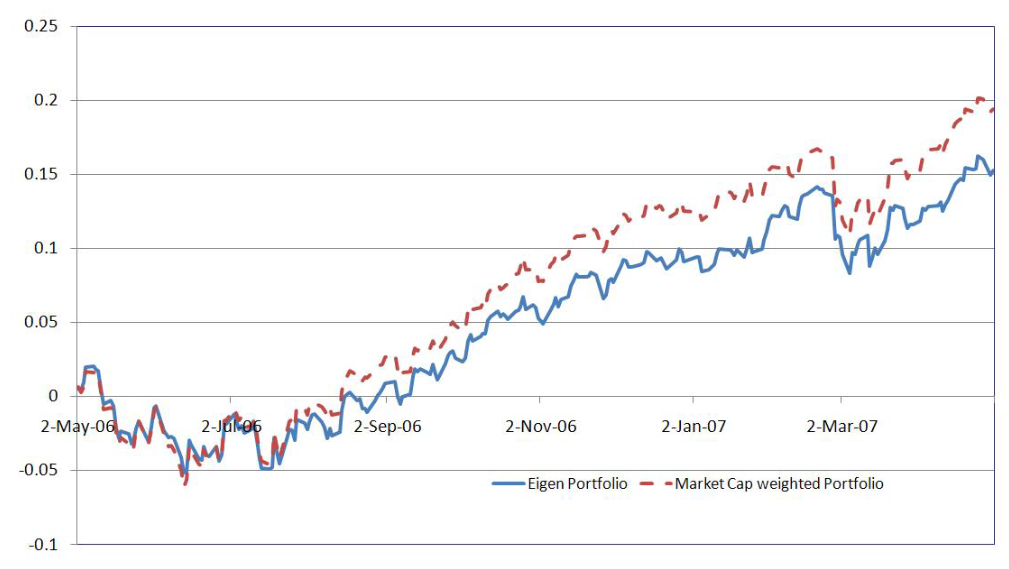

In [1]:
from IPython.display import Image
Image(filename='PCA/pca_approach_portfolio.png')

*Performance of a portfolio composed using the PCA approach in comparison to the market cap portfolio.
An example from ["Statistical Arbitrage in the U.S. Equities Market"](https://math.nyu.edu/faculty/avellane/AvellanedaLeeStatArb20090616.pdf)
by Marco Avellaneda and Jeong-Hyun Lee.*

In a multi-factor model we assume that stock returns satisfy the system of stochastic
differential equations:

$$\frac{dS_{i}(t)}{S_{i}(t)} = \alpha_{i} dt + \sum^{N}_{j=1} \beta_{ij} \frac{dI_{j}(t)}{I_{j}(t)} + dX_{i}(t),$$

where $\beta_{ij}$ are the factor loadings.

The idiosyncratic component of the return with drift $\alpha_{i}$ is:

$$d \widetilde{X_{i}}(t) = \alpha_{i} dt + d X_{i} (t).$$

Based on the previous descriptions, a model for $X_{i}(t)$ is estimated as the Ornstein-Uhlenbeck
process:

$$dX_{i}(t) = \kappa_{i} (m_{i} - X_{i}(t))dt + \sigma_{i} dW_{i}(t), \kappa_{i} > 0.$$

which is stationary and auto-regressive with lag 1.

The parameters $\alpha_{i}, \kappa_{i}, m_{i}, \sigma_{i}$ are specific for each stock.
They are assumed to *de facto* vary slowly in relation to Brownian motion increments $dW_{i}(t)$,
in the chosen time-window. The authors of the paper were using a 60-day window to estimate the residual
processes for each stock and assumed that these parameters were constant over the window.

However, the hypothesis of parameters being constant over the time-window is being accepted
for stocks which mean reversion (the estimate of $\kappa$) is sufficiently high and is
rejected for stocks with a slow speed of mean-reversion.

An investment in a market long-short portfolio is being constructed by going long 1 dollar on the stock and
short $\beta_{ij}$ dollars on the $j$ -th factor. Expected 1-day return of such portfolio
is:

$$\alpha_{i} dt + \kappa_{i} (m_{i} - X_{i}(t))dt$$

The parameter $\kappa_{i}$ is called the speed of mean-reversion. If $\kappa \gg 1$ the
stock reverts quickly to its means and the effect of drift is negligible. As we are assuming that
the parameters of our model are constant, we are interested in stocks with fast mean-reversion,
such that:

$$\frac{1}{\kappa_{i}} \ll T_{1}$$

where $T_{1}$ is the estimation window to estimate residuals in years.

## PCA Trading Strategy

The strategy implemented in the ArbitrageLab module sets a default estimation window for the correlation
matrix as 252 days, a window for residuals estimation of 60 days ($T_{1} = 60/252$) and the
threshold for the mean reversion speed of an eigenportfolio for it to be traded so that the reversion time
is less than $1/2$ period ($\kappa > 252/30 = 8.4$).

For the process $X_{i}(t)$ the equilibrium variance is defined as:

$$\sigma_{eq,i} = \frac{\sigma_{i}}{\sqrt{2 \kappa_{i}}}$$

And the following variable is defined:

$$s_{i} = \frac{X_{i}(t)-m_{i}}{\sigma_{eq,i}}$$

This variable is called the S-score. The S-score measures the distance to the equilibrium of the cointegrated
residual in units standard deviations, i.e. how far away a given asset eigenportfolio is from the theoretical
equilibrium value associated with the model.

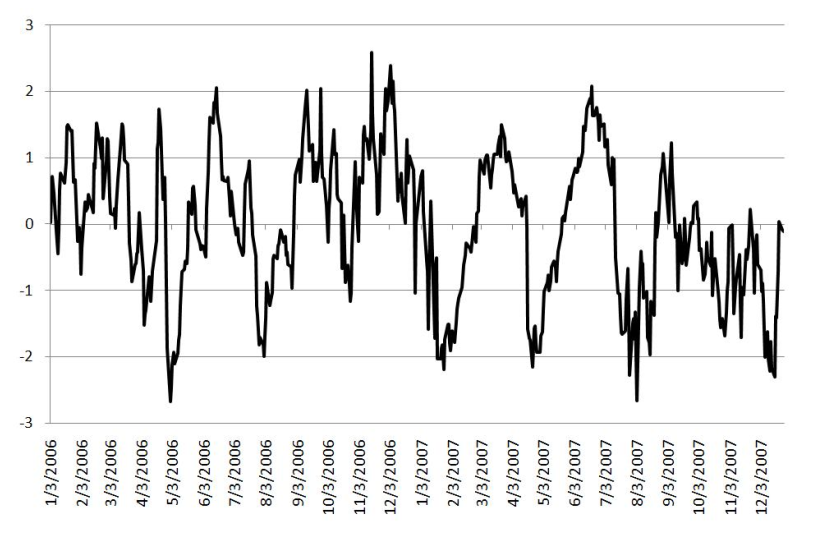

In [2]:
Image(filename='PCA/pca_approach_s_score.png')

*Evolution of the S-score of JPM ( vs. XLF ) from January 2006 to December 2007.
An example from  ["Statistical Arbitrage in the U.S. Equities Market"](https://math.nyu.edu/faculty/avellane/AvellanedaLeeStatArb20090616.pdf)
by Marco Avellaneda and Jeong-Hyun Lee.*

If the eigenportfolio shows a mean reversion speed above the set threshold ($\kappa$), the
S-score based on the values from the residual estimation window is being calculated.

The trading signals are generated from the S-scores using the following rules:

- Open a long position if $s_{i} < - \bar{s_{bo}}$

- Close a long position if $s_{i} < + \bar{s_{bc}}$

- Open a short position if $s_{i} > + \bar{s_{so}}$

- Close a short position if $s_{i} > - \bar{s_{sc}}$

Opening a long position means buying 1 dollar of the corresponding stock (of the asset eigenportfolio)
and selling $\beta_{i1}$ dollars of assets from the first scaled eigenvector ($Q^{(1)}_{i}$),
$\beta_{i2}$ from the second scaled eigenvector ($Q^{(2)}_{i}$) and so on.

Opening a short position, on the other hand, means selling 1 dollar of the corresponding stock and buying
respective beta values of stocks from scaled eigenvectors.

Authors of the paper, based on empirical analysis chose the following cutoffs. They were selected
based on simulating strategies from 2000 to 2004 in the case of ETF factors:

- $\bar{s_{bo}} = \bar{s_{so}} = 1.25$

- $\bar{s_{bc}} = 0.75$, $\bar{s_{sc}} = 0.50$

The rationale behind this strategy is that we open trades when the eigenportfolio shows good mean
reversion speed and its S-score is far from the equilibrium, as we think that we detected an anomalous
excursion of the co-integration residual. We expect most of the assets in our portfolio to be near
equilibrium most of the time, so we are closing trades at values close to zero.

The signal generating function implemented in the ArbitrageLab package outputs target weights for each
asset in our portfolio for each observation time - target weights here are the sum of weights of all
eigenportfolios that show high mean reversion speed and have needed S-score value at a given time.

## Usage of the Algorithms

Let's use the above tools on real data. 

First, we will choose a set of stocks to apply the PCA approach to. Then we will go through the steps of the PCA approach and we'll generate trading signals using the PCA Strategy. Finally, we will analyze the obtained results. 

In [3]:
import arbitragelab as al
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

### Loading data

We picked a set containing 176 stocks to apply the PCA Approach to. We'll be looking at a period of years 2018-2019. We'll eventually get trading signals for the year 2019, as the observations from the year 2018 will be needed to estimate the correlation matrix to get the PCA components.  

In [4]:
# List of tickers to use in the analysis
tickers = ['MMM', 'ABT', 'ANF', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD',
           'AKAM', 'AA', 'ALXN', 'ATI', 'ALL', 'MO', 'AMZN', 'AEE',
           'AEP', 'AXP', 'AIG', 'AMT', 'AMP', 'ABC', 'AMGN', 'APH', 'ADI', 'AON',
           'APA', 'AIV', 'AAPL', 'AMAT', 'ADM', 'AIZ', 'T', 'ADSK', 'ADP', 'AN',
           'AZO', 'AVB', 'AVY', 'BLL', 'BAC', 'BK', 'BAX', 'BDX', 'BBBY', 'BIG',
           'BIIB', 'BLK', 'HRB', 'BA', 'BWA', 'BXP', 'BSX', 'BMY', 'CHRW', 'COG',
           'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CAT', 'CNP', 'CERN', 'CF', 'SCHW',
           'CVX', 'CMG', 'CB', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CTXS', 'CLF',
           'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP',
           'CNX', 'ED', 'STZ', 'GLW', 'COST', 'CCI', 'CSX', 'CMI', 'CVS', 'DHI',
           'DHR', 'DRI', 'DVA', 'DE', 'XRAY', 'DVN', 'DFS', 'DISCA',
           'DLTR', 'D', 'RRD', 'DOV', 'DTE', 'DD', 'DUK', 'ETFC', 'EMN',
           'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'EMR', 'ETR', 'EOG', 'EQT',
           'EFX', 'EQR', 'EL', 'EXC', 'EXPE', 'EXPD', 'XOM', 'FFIV', 'FAST', 'FDX',
           'FIS', 'FITB', 'FHN', 'FSLR', 'FE', 'FISV', 'FLIR', 'FLS', 'FLR', 'FMC',
           'FTI', 'F', 'FOSL', 'BEN', 'FCX', 'GME', 'GPS', 'GD', 'GE', 'GIS',
           'GPC', 'GNW', 'GILD', 'GS', 'GT', 'GOOG', 'GWW', 'HAL', 'HOG', 'HIG',
           'HAS', 'HP', 'HES', 'HPQ', 'HD', 'HON', 'HRL', 'HST', 'HUM', 'HBAN',
           'ITW']

# Loading data
data =  yf.download(tickers, start="2018-01-03", end="2019-12-31")

# Taking close prices for chosen instruments
data = data["Adj Close"]

# Looking at the downloaded data
data.head()

[*********************100%***********************]  176 of 176 completed


,A,AA,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,...,KMX,KO,MMM,MO,RRD,SCHW,STZ,T,XOM,XRAY
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,65.985886,55.169998,41.105534,89.101776,55.908627,146.872910,177.699997,85.325447,36.638168,109.238663,...,64.760002,41.577404,215.948410,58.734520,8.693686,49.142529,216.491425,32.041576,72.152405,65.617424
2018-01-03,67.664825,54.500000,41.098373,89.433365,56.032253,147.550751,181.039993,86.383995,36.354858,110.425331,...,66.940002,41.486099,215.939209,58.518658,8.377388,49.218956,217.389648,31.301641,73.569473,65.392639
2018-01-04,67.157242,54.700001,41.289268,89.234398,55.937157,149.297852,183.220001,86.289490,36.967171,111.480156,...,68.250000,42.070415,218.761826,58.286175,8.531018,49.496006,215.755630,31.592627,73.671303,65.382851
2018-01-05,68.230972,54.090000,41.759361,90.314545,56.098827,150.529449,185.339996,86.639168,36.720421,111.414223,...,71.040001,42.061275,220.466415,58.452229,8.576202,49.687077,210.108292,31.709024,73.611900,66.301537
2018-01-08,68.377396,55.000000,41.604263,91.811577,55.937157,151.732376,185.039993,86.790382,36.638168,111.075172,...,70.050003,41.997375,219.751572,58.377499,8.594278,49.906803,207.203400,31.800476,73.942833,66.751122


In [5]:
# As our method takes in returns, we'll calculate them from our dataframe of prices
returns = data.pct_change()[1:]

# Looking at the obtrined returns series
returns.head()

,A,AA,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,...,KMX,KO,MMM,MO,RRD,SCHW,STZ,T,XOM,XRAY
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03,0.025444,-0.012144,-0.000174,0.003721,0.002211,0.004615,0.018796,0.012406,-0.007733,0.010863,...,0.033663,-0.002196,-0.000043,-0.003675,-0.036383,0.001555,0.004149,-0.023093,0.019640,-0.003426
2018-01-04,-0.007501,0.003670,0.004645,-0.002225,-0.001697,0.011841,0.012042,-0.001094,0.016843,0.009552,...,0.019570,0.014085,0.013071,-0.003973,0.018339,0.005629,-0.007517,0.009296,0.001384,-0.000150
2018-01-05,0.015988,-0.011152,0.011385,0.012105,0.002890,0.008249,0.011571,0.004052,-0.006675,-0.000591,...,0.040879,-0.000217,0.007792,0.002849,0.005296,0.003860,-0.026175,0.003684,-0.000806,0.014051
2018-01-08,0.002146,0.016824,-0.003714,0.016576,-0.002882,0.007991,-0.001619,0.001745,-0.002240,-0.003043,...,-0.013936,-0.001519,-0.003242,-0.001278,0.002108,0.004422,-0.013826,0.002884,0.004496,0.006781
2018-01-09,0.024554,-0.014545,-0.000115,0.006398,0.001700,0.003335,0.008971,-0.002069,0.003243,0.006953,...,-0.003569,0.005000,0.006214,-0.010525,-0.019979,0.021057,0.024165,-0.006887,-0.004246,-0.041728


We will go now through the steps of calculating S-scores for a window of observations to explain how the PCA approach works and will then generate treading signals.

In [6]:
# Starting with setting a PCAStrategy class with 15 principal components
pca_strategy = al.other_approaches.PCAStrategy(n_components=15)

In [7]:
# To get the factor weights from PCA we'll be using a window with 252 observations as in the original paper
data_252days = returns[:252]

# We can standardize our data
standardized_252days = pca_strategy.standardize_data(data_252days)

# But the function for calculation of the factor weights using PCA will do it by itself
factorweights = pca_strategy.get_factorweights(data_252days)

# Looking at the factor weights
factorweights

,A,AA,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,...,KMX,KO,MMM,MO,RRD,SCHW,STZ,T,XOM,XRAY
0,5.162619,2.213370,4.722126,3.519811,7.027177,6.983406,3.968961,5.021450,7.177992,6.757773,...,3.739754,7.587772,6.930543,3.075567,1.442290,5.683200,4.579650,4.438863,6.374332,2.377683
1,0.512819,2.483863,0.982026,-0.485030,-0.619607,-0.219090,1.338507,2.371404,-3.670758,-2.237417,...,0.471022,-14.157574,-0.475461,-5.090956,0.666876,3.611700,-0.817239,-1.620622,0.352320,-0.814133
2,-6.740185,-2.292468,-7.188881,5.831769,-6.718145,-5.053580,-8.932055,-3.645106,6.945074,-6.138593,...,2.212142,8.409849,-1.928771,8.004050,2.157249,2.536675,-2.182615,9.125683,-1.926157,2.172649
3,-4.424260,1.787644,-1.283511,-0.797591,-4.658968,-2.862701,-4.568218,-4.550549,3.495490,-4.506701,...,0.941037,-0.067532,-1.628012,1.124297,-0.827247,-1.973762,3.590543,2.907265,14.929317,-0.218246
4,0.158958,1.231271,-2.748405,-4.895718,1.594462,0.644135,-2.242732,-1.856054,-9.958468,3.568564,...,-7.240843,0.376849,6.025026,-5.710120,-1.123713,6.279396,-3.898006,0.319101,2.424419,-4.728786
5,-4.205214,-0.237123,4.995148,3.330564,-1.790889,1.764947,3.946410,-1.571248,1.674184,5.726053,...,-1.578355,-7.690039,-9.915705,-4.304820,-0.327694,4.913773,5.896447,-3.943709,1.456548,0.300691
6,-1.999394,-0.798293,-0.258703,-9.637965,-4.963385,-1.420821,0.690395,0.972640,-4.738065,0.538655,...,3.036752,-3.651515,-2.480219,-2.491389,0.391475,3.410242,-0.209679,-7.729533,-1.967438,-6.631589
7,-1.732123,4.821387,2.961264,4.931024,-1.973384,-5.477233,0.064406,8.090522,-0.946315,0.025902,...,2.380171,-8.168225,-1.414024,-5.733863,1.534785,0.470241,-1.219445,0.601677,-3.168736,7.399011
8,6.106441,-0.070071,-0.871051,4.063853,-0.901251,-0.581011,1.066726,3.443282,-4.133284,-1.852266,...,3.931826,6.938758,2.241751,8.689939,0.150177,-0.376811,-1.336694,1.493357,4.272188,-3.790885
9,3.473478,1.935907,2.687800,-0.556473,-3.118744,0.328573,-1.361050,9.078793,2.026452,-3.116066,...,-4.039838,5.443559,2.410622,-1.425634,-3.380228,5.598297,-3.975058,-2.806168,1.439698,2.019127


Our factor weights are 15 first components from the PCA divided by the standard deviations of returns of our assets.

Now we can get a 60-day window of observations to calculate residuals and coefficients. The calculation is done by fitting a linear regression on the returns from this window and factor returns from this window.

In [8]:
# Getting a 60-day window of observations to calculate factor returns
data_60days = returns[(252-60):252]

# Last day in our window
data_60days.index[-1]

Timestamp('2019-01-02 00:00:00')

In [9]:
# Calculating factor returns from our returns - multiplying them by factor weights
factorret = pd.DataFrame(np.dot(data_60days, factorweights.transpose()), index=data_60days.index)

# Looking at the obtained factor returns
factorret.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Date,,,,,,,,,,,,,,,
2018-10-08,1.088695,-4.425308,5.904507,1.491467,-1.110469,-0.322017,0.693967,-0.736993,0.357286,0.052498,0.673867,0.109747,0.635917,0.321304,0.410909
2018-10-09,-3.635328,-2.428258,-1.999952,2.078045,0.153218,5.331796,-1.262596,-2.827488,1.766319,-0.057352,1.131503,0.268121,0.242324,0.873544,0.624591
2018-10-10,-23.554099,-0.660171,4.178387,0.057958,-2.553203,0.518114,-0.047029,1.353402,0.558087,0.926006,-1.344968,-1.956729,-0.926252,-1.572557,0.239068
2018-10-11,-18.643226,7.200969,-4.530207,-0.942356,-2.357991,-1.936456,2.217582,1.959116,-3.124026,1.287816,0.342419,0.141757,-2.039890,2.621814,1.782035
2018-10-12,6.471328,0.885610,-5.142652,-1.861684,-2.279741,0.528677,-1.848002,-0.543826,-1.024566,0.374882,-0.637504,0.988464,-2.619760,-0.502834,-0.435409


So for each component from PCA and for each observation we get a return value. 

In [10]:
# Now fitting the linear regression to get residuals and coefficients of the regression
residual, coefficient = pca_strategy.get_residuals(data_60days, factorret)

# Residuals dataframe
residual.head()

,A,AA,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,...,KMX,KO,MMM,MO,RRD,SCHW,STZ,T,XOM,XRAY
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-08,0.003810,-0.055886,0.013468,-0.007067,0.004205,-0.005137,0.002045,0.004043,0.002142,-0.000790,...,0.000204,0.001672,0.008728,0.003358,-0.044787,0.005613,0.029568,-0.013015,0.002052,-0.009968
2018-10-09,-0.008096,0.009085,0.008340,-0.003455,0.002443,-0.009338,-0.019301,0.021537,0.000651,-0.002990,...,0.003728,-0.000375,-0.004991,-0.004936,0.033405,0.019096,-0.008281,0.006182,-0.000945,-0.003395
2018-10-10,0.003298,0.012320,0.000910,0.007719,0.006634,-0.001664,-0.006763,0.001292,-0.010718,-0.011042,...,-0.023281,-0.001486,0.001775,0.004762,0.032793,-0.005156,-0.003042,-0.003338,0.005423,0.011773
2018-10-11,-0.005176,0.001687,0.000529,-0.004204,0.011505,-0.010014,0.014856,-0.000174,-0.005500,-0.002981,...,0.000808,0.000191,0.000554,0.002300,-0.041589,0.001693,0.002539,-0.008822,-0.004861,0.003985
2018-10-12,0.007813,-0.024340,0.014087,0.007801,-0.003925,0.007454,-0.004335,-0.010649,-0.001280,-0.000916,...,-0.007752,-0.001712,-0.008589,-0.011504,0.020455,0.009608,0.024016,0.008871,-0.003694,-0.010962


In [11]:
# Coefficients dataframe
coefficient

,A,AA,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,...,KMX,KO,MMM,MO,RRD,SCHW,STZ,T,XOM,XRAY
0,0.001123,0.002041,0.001786,0.001088,0.001497,0.001385,0.002097,0.001508,0.001011,0.001383,...,0.001236,0.000610,0.001513,0.000614,0.001556,0.001758,0.001042,0.001169,0.001104,0.000984
1,0.000186,0.001094,0.000894,-0.000132,-0.000148,-0.000107,0.000364,0.001036,-0.000720,0.000012,...,0.000407,-0.001480,0.000002,-0.000405,0.000926,0.000776,-0.000124,0.000335,0.000004,0.000208
2,-0.002525,-0.001839,-0.002135,0.002407,-0.001357,-0.000681,-0.005786,-0.001143,0.001232,-0.001152,...,0.000060,0.000797,-0.000470,0.001602,0.003775,0.000603,-0.000692,0.002465,0.000221,0.000493
3,-0.002049,-0.000110,-0.000265,-0.000438,-0.001504,-0.000104,-0.002574,-0.001837,0.000356,-0.001338,...,0.000197,-0.000303,-0.000230,0.000158,-0.001730,-0.000161,0.001471,0.001194,0.002670,0.000322
4,0.000688,0.001458,-0.000642,-0.002410,-0.000040,0.000047,-0.002562,-0.000044,-0.001873,0.001972,...,-0.002636,0.000553,0.001282,-0.001139,0.001125,0.001918,-0.000897,-0.000406,0.000278,-0.001040
5,0.000968,-0.004002,0.002400,0.000915,-0.000717,-0.000262,0.004083,-0.000614,-0.000599,0.002292,...,0.001807,-0.000734,-0.002037,-0.000484,-0.001639,0.000540,0.000921,-0.001682,0.000039,0.001385
6,-0.000729,-0.002118,0.000869,-0.003566,-0.000030,-0.001732,0.001258,0.000307,-0.001335,-0.000149,...,0.003292,-0.000297,-0.000831,-0.000163,-0.003694,0.000779,-0.000502,-0.002511,-0.000731,-0.001256
7,-0.000217,0.002730,0.000402,0.000624,-0.001226,-0.000568,0.001248,0.002031,0.000331,-0.000452,...,0.000437,-0.000532,-0.000866,-0.001661,0.002440,-0.000050,0.001418,0.000524,-0.000332,0.002204
8,0.000960,0.000188,-0.000072,0.001055,0.000216,0.001439,0.002189,0.000092,-0.000110,-0.000751,...,-0.000345,0.000131,-0.000129,0.003306,-0.004436,-0.000148,0.000034,0.000851,0.000343,-0.000832
9,0.001725,-0.000757,0.002094,-0.000136,-0.000221,0.000304,-0.000169,0.004275,0.000825,-0.001722,...,-0.001469,-0.000412,-0.000791,0.000750,-0.007481,0.000609,-0.000993,-0.000070,-0.000899,0.000629


Using each column in the residuals dataframe we'll decide whether to trade an eigenportfolio related to that asset.
The eigenportfolio will be used if:

    a) the mean reversion speed of the OU process composed from the residuals is high enough,

    b) the OU process deviates enough from its mean value.

So, in our example, we can have up to 176 eigenportfolios. After the checks for the mean reversion speed and the S-scores are
made we might end up with about 10 eigenportfolios that are suitable to be traded. 

Using the betas - values from the coefficients dataframe the eigenportfolio will be constructed. 

For example, if we have a signal to go long on the **AA** asset eigenportfolio and we use a scaling parameter equal to one, we
will:
- go long one dollar of the **AA** asset;
- go short the **A** stock with the sum of betas from the **A** column (*coefficient* dataframe);
- go short the **AA** stock with the sum of betas from the **AA** column (*coefficient* dataframe);
- go short the **AAPL** stock with the sum of betas from the **AAPL** column (*coefficient* dataframe);
- and so on..

for each stock in a portfolio.

In [12]:
# Now, calculating the S-scores
s_scores = pca_strategy.get_sscores(residual, k=8.4)

# Picking parameters to trade based on the S-score
sbo = 1.25
sso = 1.25
ssc = 0.5
sbc = 0.75

# Stock eigenportfolios that we should long
s_scores[s_scores < -sbo]

ADI     -1.616596
AEP     -1.401570
AES     -2.263552
ALXN    -1.940683
AON     -1.602600
ATI     -1.599611
AXP     -1.392671
BAC     -1.302186
BLL     -1.423629
C       -1.436814
CAG     -1.352675
CINF    -2.071620
CMCSA   -2.049622
CMI     -1.295068
ETFC    -1.608975
FCX     -2.927114
FLS     -1.791496
HRL     -2.042624
STZ     -1.680171
dtype: float64

In [13]:
# Stock eigenportfolios that we should short
s_scores[s_scores > sso]

AFL     1.520241
AMGN    1.375944
ANF     1.611564
APD     1.900837
AVY     1.916811
BLK     1.594426
BMY     1.863794
CERN    1.418943
DHI     1.454331
EA      1.671579
EQT     1.479069
GE      1.788441
HD      1.651529
ITW     1.394837
T       1.314750
dtype: float64

So these are the S-scores for each eigenportfolio. We've printed those of them that are either above or below critical values
to enter a trade.

We should go long on 19 eigneportfolios and short on 15 eigenportfolios for this observation.

To calculate these S-scores we estimated the PCA components on the 252 trading days of the year 2018 and
calculated the residuals on the last 60 days of the year 2018. The last observation used for the estimation was
2019.01.02. So these trading signals can be used on 2019.01.03.

By moving the 60-day window one observation ahead and recalculating the residuals and the regression coefficients
we would get new S-scores and based on them we would have a trading signal for 2019.01.04.

As the estimated correlation matrix used to get the PCA factors doesn't change much, it's calculated again only once
we generated the whole residual window of signals. So in our example, it would be recalculated every 60 days using the
last 252 observations.

Now we can simply use the PCA Strategy with a single function and given input parameters to generate trading signals

**Note:** This function can be used on the raw returns dataframe. The previous steps are presented in the notebook
to explain the idea behind the PCA Strategy.

This function might take a long time to generate output, especially if given a dataframe with a big number of observations, as
to generate trading signals for a single day we have to go through the all steps mentioned above.

In [14]:
# Simply applying the PCAStrategy with standard parameters
target_weights = pca_strategy.get_signals(returns, k=8.4, corr_window=252,
                                          residual_window=60, sbo=1.25,
                                          sso=1.25, ssc=0.5, sbc=0.75,
                                          size=1)


In [15]:
# Looking at generated trading signals
target_weights.head()

,A,AA,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,...,KMX,KO,MMM,MO,RRD,SCHW,STZ,T,XOM,XRAY
2019-01-02,-0.159263,-0.159263,-0.159263,-0.159263,-0.159263,-0.159263,-0.159263,0.840737,-0.159263,-0.159263,...,-0.159263,-0.159263,-0.159263,-0.159263,-0.159263,-0.159263,0.840737,-1.159263,-0.159263,-0.159263
2019-01-03,0.186368,0.186368,0.186368,0.186368,0.186368,0.186368,-0.813632,0.186368,-0.813632,0.186368,...,0.186368,0.186368,0.186368,0.186368,0.186368,0.186368,0.186368,0.186368,1.186368,0.186368
2019-01-04,-0.001034,-0.001034,-0.001034,-0.001034,-0.001034,-0.001034,-0.001034,-0.001034,-0.001034,-0.001034,...,-0.001034,-0.001034,-0.001034,-0.001034,-0.001034,-0.001034,0.998966,-0.001034,-0.001034,-0.001034
2019-01-07,0.164683,0.164683,0.164683,0.164683,0.164683,0.164683,0.164683,0.164683,0.164683,0.164683,...,0.164683,0.164683,0.164683,0.164683,0.164683,0.164683,0.164683,-0.835317,0.164683,-0.835317
2019-01-08,0.143404,0.143404,0.143404,0.143404,0.143404,0.143404,0.143404,0.143404,0.143404,1.143404,...,0.143404,0.143404,0.143404,0.143404,0.143404,-0.856596,0.143404,0.143404,1.143404,0.143404


Now, let's normalize these weights - so that on each day we'd be long or short a sum of 1 asset units. 

In [16]:
# Normalizing weights
norm_weights = target_weights.divide(abs(target_weights).sum(axis=1), axis=0)

# Checking if the sum of absolute weights for each date is 1
abs(norm_weights).head().sum(axis=1)

2019-01-02    1.0
2019-01-03    1.0
2019-01-04    1.0
2019-01-07    1.0
2019-01-08    1.0
dtype: float64

In [17]:
# Returns dataframe
returns_test = returns[(252 - 1):-1]

# Checking that our returns dataframe have the same index as the trading signals dataframe
returns_test.head()

,A,AA,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,...,KMX,KO,MMM,MO,RRD,SCHW,STZ,T,XOM,XRAY
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,-0.026238,-0.012792,0.001141,0.000672,-0.039126,-0.002979,-0.007382,0.001048,-0.000488,-0.007474,...,0.003826,-0.008870,0.002152,-0.001620,0.078283,0.001204,0.020022,0.035039,0.021997,0.018275
2019-01-03,-0.036840,0.000000,-0.099607,-0.014506,-0.047194,-0.034142,-0.039498,-0.060405,-0.004396,-0.030198,...,-0.017151,-0.006179,-0.037654,-0.005476,-0.053864,-0.020683,-0.014874,0.001354,-0.015354,0.000528
2019-01-04,0.034614,0.080031,0.042689,0.011585,0.028541,0.038884,0.048632,0.024278,0.023056,0.039854,...,0.027791,0.019940,0.041141,0.025693,0.069307,0.042240,0.031064,0.025693,0.036869,0.029016
2019-01-07,0.021234,0.002823,-0.002226,0.007141,0.014976,0.003474,0.013573,0.006288,0.005035,-0.005410,...,0.044333,-0.013033,-0.002300,-0.030219,0.032407,0.007069,0.021006,0.018128,0.005200,0.017944
2019-01-08,0.014660,-0.005982,0.019063,0.010702,-0.012006,0.025290,0.014918,0.024396,0.018607,0.005899,...,-0.022881,0.011289,0.004191,0.005740,0.033632,0.012635,0.013050,0.012626,0.007271,-0.006800


In [18]:
# Shifting the trading signal dataframe one observation further,
# as we would be able to use those signals on the following day
investment_portfolio_returns = (returns_test * norm_weights.shift(1)).sum(axis=1)

# Calculating the portfolio price of our investment portfolio
investment_portfolio_price = (investment_portfolio_returns + 1).cumprod()

# And calculating the equity curve of our investment portfolio
equity_curve = investment_portfolio_price  - 1

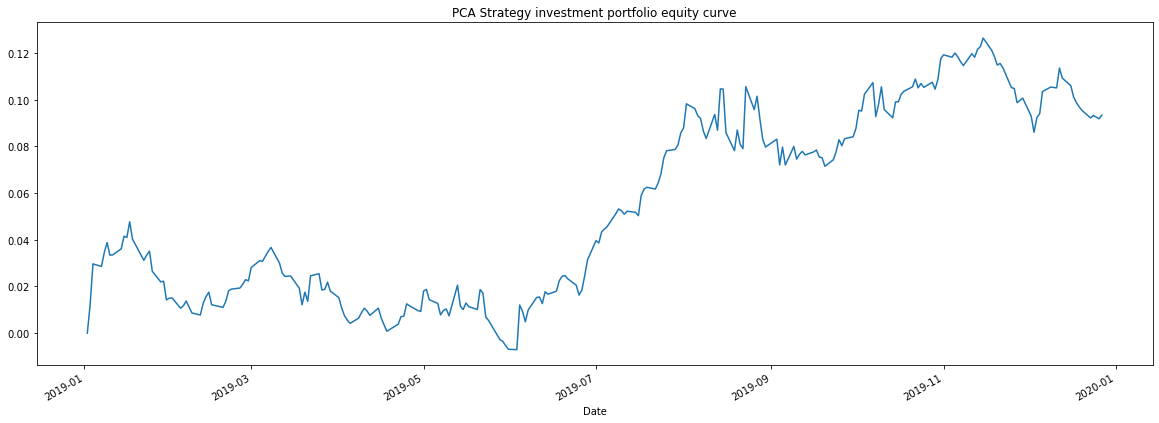

In [19]:
# Plotting the equity curve
equity_curve.plot(figsize = (20,7),
                  title='PCA Strategy investment portfolio equity curve');

These results look good, over the year 2019 equity curve shows an increase in the investment portfolio value from 1 to around 1,1. 

We can further test this strategy by choosing different critical values for the S-score, increasing the mean reversion speed threshold, or adding transaction costs to see if the strategy is robust.

## Conclusion

This notebook describes the PCA Strategy class and its functionality. Also, it shows how the tools can be used on real data.

The algorithms used in this notebook were described by _Marco Avellaneda_ and _Jeong-Hyun Lee_ in the paper __Statistical Arbitrage in the U.S. Equities Market__  [available here](https://math.nyu.edu/faculty/avellane/AvellanedaLeeStatArb20090616.pdf).

Key takeaways from the notebook:
- Principal Component Analysis can be used to create mean-reverting portfolios and generate trading signals.
- First, a window of 252 observations is used to get an empirical correlation matrix and use the PCA to get N top components.
- It’s important to standardize data before inputting it to PCA, as the PCA seeks to maximize the variance of each component.
- A separate market-neutral eigenportfolio can be calculated for each stock in our portfolio.
- Next, we pick a window to calculate residuals (60 days in the example).
- By using linear regression on the second window (60-days) and factor returns for this window we get residuals and the coefficients of regression.
- These residuals are used to construct an OU process for each eigenportfolio.
- If the OU process shows a high (above the $\kappa$ threshold) speed of mean reversion, we calculate the s-score for it.
- S-score is measuring how far away a given asset eigenportfolio is from the theoretical equilibrium value associated with the model.
- If the S-score is too high or too low we generate a signal to sell or buy this eigenportfolio.
- Resulting trading signal is the sum of all eigenportfolio weights that satisfy the requirements to be traded.
- Parameters to optimize in this strategy are the mean reversion speed threshold, the windows for PCA and residual calculation, and the S-score thresholds to enter or exit positions. 